In [1]:
# python3 -m pip install clickhouse-driver

import os,sys
from clickhouse_driver import connect,Client

sys.path.append("../")

# you need a ~/.nsdf/vault/vault.yaml file

use_nsdf=True
if use_nsdf:
	from nsdf.kernel import NormalizeEnv, SetEnv
	SetEnv(NormalizeEnv({
		"include-vault": [
			"s3-cloudbank",
			"clickhouse"
		]
	}))
else:
	
	# change as needed
	os.environ["AWS_ACCESS_KEY_ID"]="XXXXX"
	os.environ["AWS_SECRET_ACCESS_KEY"]="YYYYY"

	os.environ["CLICKHOUSE_HOST"]="rw.chcql1nlq37luu78jtmk.at.double.cloud"
	os.environ["CLICKHOUSE_PORT"]=9440
	os.environ["CLICKHOUSE_USER"]="admin"
	os.environ["CLICKHOUSE_PASSWORD"]="ZZZZZ"

AWS_ACCESS_KEY_ID     = os.environ["AWS_ACCESS_KEY_ID"]
AWS_SECRET_ACCESS_KEY = os.environ["AWS_SECRET_ACCESS_KEY"]
AWS_ENDPOINT_URL      = os.environ["AWS_ENDPOINT_URL"]

CLICKHOUSE_HOST       = os.environ["CLICKHOUSE_HOST"]
CLICKHOUSE_PORT       = os.environ["CLICKHOUSE_PORT"]
CLICKHOUSE_USER       = os.environ["CLICKHOUSE_USER"]
CLICKHOUSE_PASSWORD   = os.environ["CLICKHOUSE_PASSWORD"]

BUCKET		= "nsdf-catalog"

# ////////////////////////////////////////////////////////////////////////
def RunShellCommand(cmd):
	import shlex,subprocess
	print(cmd)
	result=subprocess.run(shlex.split(cmd), shell=False, check=False,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
	print(f"Run {cmd} returncode={result.returncode}")
	print(result.stdout.decode('utf-8'))

# ////////////////////////////////////////////////////////////////////////
def RunClientCommand(query, prefix_cmd="", allow_errors=0):
	assert '"'  not in query
	assert "$"  not in query
	cmd=f"clickhouse-client  --host {CLICKHOUSE_HOST} --port {CLICKHOUSE_PORT} --secure --user {CLICKHOUSE_USER} --password {CLICKHOUSE_PASSWORD} --query=\"{query}\""
	
	if prefix_cmd:
		cmd=prefix_cmd + " " + cmd

	if allow_errors:
		cmd=cmd + f" --input_format_allow_errors_num={allow_errors}"
	RunShellCommand(cmd)
	
# ////////////////////////////////////////////////////////////////////////
def InsertRecordsFromS3(prefix, allow_errors=0):
	"""
	https://dzone.com/articles/clickhouse-s3-compatible-object-storage
	"""
	return RunClientCommand(f"INSERT INTO nsdf.catalog SELECT * FROM s3('{prefix}','{AWS_ACCESS_KEY_ID}', '{AWS_SECRET_ACCESS_KEY}', 'CSV');")

# ////////////////////////////////////////////////////////////////////////
def InsertRecordsFromCSV(filename):
	RunClientCommand("INSERT INTO nsdf.catalog FORMAT CSV", prefix_cmd=f"cat {filename} |")

# ////////////////////////////////////////////////////////////////////////
def Connect():
	return Client(host=CLICKHOUSE_HOST, port=str(CLICKHOUSE_PORT), user=CLICKHOUSE_USER, password=CLICKHOUSE_PASSWORD, secure=True)

client = Connect()
client.execute("""CREATE DATABASE IF NOT EXISTS nsdf""")
# client.execute("""SHOW DATABASES""")
# client.execute("""DROP TABLE IF EXISTS nsdf.catalog""")
client.execute("""CREATE TABLE IF NOT EXISTS nsdf.catalog(
		catalog	 varchar(64),
		bucket	  varchar(64),
		name            varchar(1024),
		size            BIGINT,
		last_modified   varchar(32) NULL,
		etag            varchar(256) NULL
	) 
	ENGINE = MergeTree() 
	ORDER BY(catalog,bucket)
""")

!!!!! rw.chcql1nlq37luu78jtmk.at.double.cloud 9440


[]

In [2]:
# check AWS credentials work
if False:
	RunShellCommand(f"aws s3 --endpoint-url {AWS_ENDPOINT_URL} ls s3://{BUCKET}/mc/")
	RunShellCommand(f"aws s3 --endpoint-url {AWS_ENDPOINT_URL} ls s3://{BUCKET}/aws-open-data/")
	RunShellCommand(f"aws s3 --endpoint-url {AWS_ENDPOINT_URL} ls s3://{BUCKET}/digitalrocksportal/projects/")
	RunShellCommand(f"aws s3 --endpoint-url {AWS_ENDPOINT_URL} ls s3://{BUCKET}/20220624/csv/mdf/")
	RunShellCommand(f"aws s3 --endpoint-url {AWS_ENDPOINT_URL} ls s3://{BUCKET}/arecibo/")
	RunShellCommand(f"aws s3 --endpoint-url {AWS_ENDPOINT_URL} ls s3://{BUCKET}/ranch/")

In [3]:
# Examples of SQL INSERT (with statistics)

# 25 seconds, 129,117 files, 5,533,076,354,245 (~5TB)
# InsertRecordsFromS3(f"{AWS_ENDPOINT_URL}/{BUCKET}/mc/*.csv")

# 4m 51 seconds, 49,995,452 files, 10,531,224,818,071,513 (~10PB) todo... records I think are more than that
# InsertRecordsFromS3(f"{AWS_ENDPOINT_URL}/{BUCKET}/aws-open-data/*.csv")

# 42 seconds, 8,638 files, 3,328,980,888,119 (~3TB)
# InsertRecordsFromS3(f"{AWS_ENDPOINT_URL}/{BUCKET}/digitalrocksportal/projects/*.csv")

# 2m 39 seconds, 1,075,706 files, 5,243,595,789,858 (~5TB)
# InsertRecordsFromS3(f"{AWS_ENDPOINT_URL}/{BUCKET}/20220624/csv/mdf/*.csv")

# <2m, 2,045,049 files, 491,912,368,698,644 total size (~500TB)
# InsertRecordsFromS3(f"{AWS_ENDPOINT_URL}/{BUCKET}/arecibo/*.csv")

# <2m,  3,745,760 files, 36,750,124,831,337,770 (~34PB)
# InsertRecordsFromS3(f"{AWS_ENDPOINT_URL}/{BUCKET}/ranch/*.csv", allow_errors=9999999999)

In [5]:
# total count per catalog
my_table = client.execute("""
select catalog,COUNT(size),SUM(size)
from nsdf.catalog
group by catalog;
""")

In [29]:
def AddSuffix(number,type="", base=1024):
	if number < (base**2): return str(number//(base**0))+type
	if number < (base**2): return str(number//(base**1))+"K"+type
	if number < (base**3): return str(number//(base**2))+"M"+type
	if number < (base**4): return str(number//(base**3))+"G"+type
	if number < (base**5): return str(number//(base**4))+"T"+type
	return str(number//(base**5))+"P"+type

def PrintInfo(name,count,size):
	print("repository =",name.ljust(19)
		," - number of files =",AddSuffix(count,base=1000).ljust(7)
		," - total file size =",AddSuffix(size,base=1024,type="B").ljust(7))

if True:
	tot_count,tot_size= 0,0
	for name,count,size in my_table:
		tot_count += count
		tot_size += size
	my_table = [["all repositories",tot_count,tot_size]]+my_table

	my_table.sort(key=lambda x:-x[2])
	repository_table = list(my_table)
	for name,count,size in my_table:
		PrintInfo(name,count,size)

repository = all repositories     - number of files = 227M     - total file size = 169PB  
repository = all repositories     - number of files = 113M     - total file size = 84PB   
repository = all repositories     - number of files = 56M      - total file size = 42PB   
repository = ranch                - number of files = 3M       - total file size = 32PB   
repository = aws-open-data        - number of files = 49M      - total file size = 9PB    
repository = arecibo              - number of files = 2M       - total file size = 447TB  
repository = mc                   - number of files = 129117   - total file size = 5TB    
repository = mdf                  - number of files = 1M       - total file size = 4TB    
repository = digitalrocksportal   - number of files = 8638     - total file size = 3TB    
repository = all projects         - number of files = 0        - total file size = 0B     


In [8]:
import os,sys
from pprint import pprint

# print all buckets
buckets=[it for it in client.execute(f"SELECT DISTINCT catalog,bucket FROM nsdf.catalog")]
print(buckets[0:10])

[('aws-open-data', 'cbers-meta-pds'), ('aws-open-data', 'njogis-elevation'), ('aws-open-data', '1000genomes'), ('aws-open-data', 'nrel-pds-porotomo'), ('aws-open-data', 'njogis-imagery'), ('aws-open-data', 'noaa-bathymetry-pds'), ('aws-open-data', 'cgiardata'), ('aws-open-data', 'civic-aws-opendata'), ('aws-open-data', 'cmas-amet'), ('aws-open-data', 'cmas-cmaq-conus2-benchmark')]


In [30]:
def GetFileNames (catalog = None, group_buckets = False, group_suffix = False):
	if group_buckets: 
		grouping = "catalog, bucket"
		selecting ="catalog, bucket"
		header=["repository", "bucket", "file count", "files sizes"]
	elif group_suffix:
		grouping  = "catalog, suffix"
		selecting = "catalog, suffix"
		header=["repository", "suffix","file count", "files sizes"]
	else:
		grouping="catalog, bucket, suffix"
		selecting = "catalog, bucket, suffix"
		header=["repository", "bucket", "suffix","file count", "files sizes"]

	catalog_restriction = f"catalog='{catalog}'" if catalog is not None else  "1==1"
 
	ret = client.execute(f"""
		SELECT {selecting},count(size) as NumSize,SUM(size) as TotSize
		FROM (
			SELECT 
				arrayStringConcat(['.',splitByChar('.',name)[-1]]) as suffix,
				size as size , 
				catalog, 
				bucket
			FROM 
				nsdf.catalog
			WHERE {catalog_restriction} AND (
				name like '_%._'   OR 
				name like '_%.__'  OR 
				name like '_%.___' OR 
				name like '_%.____'   )
			) derived_table 
			GROUP BY {grouping} 
			ORDER BY NumSize DESC;
	""")

	return [header, ret]

if True:
	header,rows = GetFileNames()
	print (header)
	for I,row in enumerate(rows):
		print(row)
		if I>=10: break

['repository', 'bucket', 'suffix', 'file count', 'files sizes']
('aws-open-data', 'nrel-pds-porotomo', '.sac', 4749114, 2423013479096)
('aws-open-data', 'amazon-berkeley-objects', '.jpg', 1383551, 162902652787)
('aws-open-data', 'noaa-isd-pds', '.gz', 1344396, 133546936385)
('aws-open-data', 'noaa-cdr-microwave-imager-brit-temp-csu-pds', '.nc', 1213540, 16124579915690)
('aws-open-data', 'esgf-world', '.nc', 1154824, 729500752365989)
('aws-open-data', 'sentinel-1-global-coherence-earthbigdata', '.tif', 1033510, 1324914058886)
('aws-open-data', 'ncar-cesm-lens', '.0', 1033032, 90882699579430)
('aws-open-data', 'mogreps-g', '.nc', 1017548, 43371723047556)
('aws-open-data', 'noaa-nos-ofs-pds', '.nc', 874376, 91944116452097)
('aws-open-data', 'noaa-nwm-pds', '.nc', 838566, 32208530206818)
('aws-open-data', 'encode-public', '.gz', 682260, 241887383679134)


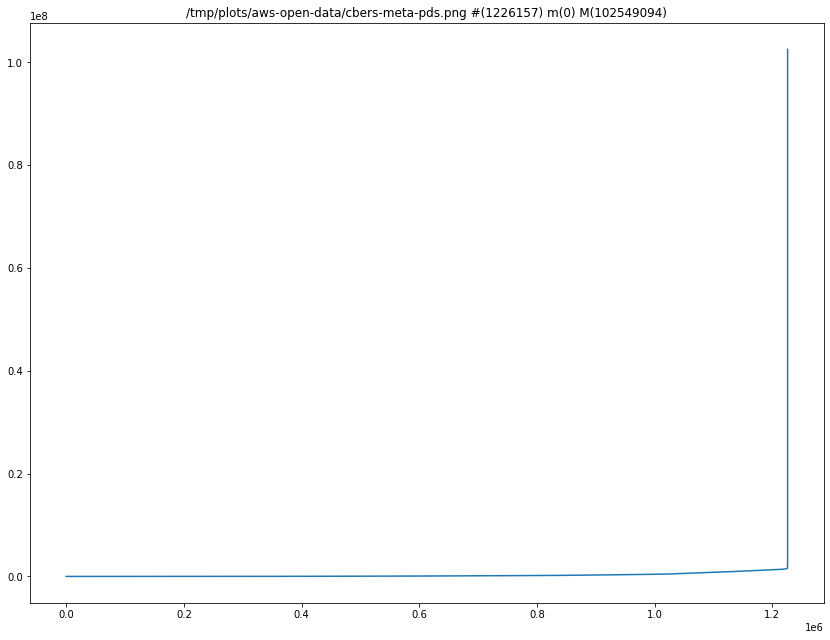

In [11]:
# example of plot of filesize inside a dataset
import pandas as pd
import matplotlib.pyplot as plt

def PlotSizes(filename,sizes):
	sizes=sorted(sizes)
	ipd = 1/plt.rcParams['figure.dpi'] 
	plt.figure(figsize=(1024*ipd,768*ipd))
	plt.title(f"{filename} #({len(sizes)}) m({sizes[0]}) M({sizes[-1]})")
	plt.plot(range(len(sizes)), sorted(sizes))
	os.makedirs(os.path.dirname(filename),exist_ok=True)
	plt.savefig(filename)
	plt.show()

if True:
	for catalog, bucket in buckets:
		sizes=[it[0] for it in client.execute(f"SELECT size FROM nsdf.catalog WHERE catalog='{catalog}' and bucket='{bucket}'")]
		if not sizes: continue
		PlotSizes(filename=f"/tmp/plots/{catalog}/{bucket}.png",sizes=sizes)
		# remove the `break` if you want all the plots
		break 

In [31]:
# total records 56M files 44PB
client = Connect()
TOT_FILES,TOT_BYTES=client.execute(f"SELECT count(size),SUM(size)/(1024*1024*1024) FROM nsdf.catalog;")[0]
print(TOT_FILES,TOT_BYTES)

!!!!! rw.chcql1nlq37luu78jtmk.at.double.cloud 9440
56999722 44505454.29358273


In [ ]:
# # total size per catalog/bucket
client.execute("""
	SELECT catalog,bucket, SUM(size) as TotSize
	FROM nsdf.catalog
	GROUP BY catalog,bucket
	ORDER BY TotSize DESC;
	""")

In [ ]:
# total number of objeccts per catalog/bucket
client.execute("""
	SELECT catalog,bucket, COUNT(size) As NumObjects
	FROM nsdf.catalog
	group by catalog,bucket
	ORDER BY NumObjects DESC;
""")

In [15]:
# example of looking to a specific catalog,bucket
client.execute("""
	SELECT SUM(size) from nsdf.catalog 
	WHERE catalog='aws-open-data' and bucket='noaa-cors-pds';
""")


[(0,)]

In [16]:
# LIKE querry for looking into filenames
client.execute("""
	SELECT count(*) from nsdf.catalog
	where name like '%a%'
""")

[(44557293,)]

In [17]:
# size per catalog
client.execute("""
	SELECT catalog,SUM(size)
	FROM nsdf.catalog
	GROUP BY catalog;
""")

[('arecibo', 491912368698644),
 ('ranch', 36750124831337770),
 ('mdf', 5243595789858),
 ('mc', 5533076354245),
 ('aws-open-data', 10531224818071513),
 ('digitalrocksportal', 3328980888119)]

In [ ]:
# SUM per bucket
client.execute("""
	SELECT catalog,bucket,SUM(size)
	FROM nsdf.catalog
	GROUP BY catalog,bucket
	ORDER BY COUNT(size) DESC;
""")

In [ ]:
# COUNT per bucket 
client.execute("""
	SELECT catalog,bucket,COUNT(size)
	FROM nsdf.catalog
	GROUP BY catalog,bucket
	ORDER BY COUNT(size) DESC;
""")

In [ ]:
# file size distribution 
client.execute("""
	SELECT size
	FROM nsdf.catalog
	WHERE catalog='mc' and bucket='102'
	ORDER BY size ASC;
""")

In [ ]:
# delete records
# ALTER TABLE nsdf.catalog DELETE WHERE 1=1;

In [23]:
# get extension
client.execute("""
	SELECT splitByChar('.','giorgio.scorzelli.h5')[-1]
	FROM nsdf.catalog             
	ORDER BY size DESC
	LIMIT 10
""")

[('h5',),
 ('h5',),
 ('h5',),
 ('h5',),
 ('h5',),
 ('h5',),
 ('h5',),
 ('h5',),
 ('h5',),
 ('h5',)]

In [32]:
import yaml

from bokeh.layouts import row,column
from bokeh.models.widgets import Div
from bokeh.models import ColumnDataSource, Slider , Dropdown, Select, DataTable,TableColumn, Button, Dropdown
from bokeh.plotting import figure, curdoc
from bokeh.themes import Theme
from bokeh.io import show, output_notebook, curdoc
from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

from IPython.display import clear_output
from IPython.display import IFrame

import requests
from requests.exceptions import HTTPError

def in_notebook():
	from IPython import get_ipython
	return True if get_ipython() else False

In [33]:
if in_notebook():
	output_notebook()

Loading BokehJS ...

In [34]:
repository_table2=[]
for name,count,size in repository_table:
	repository_table2.append([
		name,
		format(count, ",").rjust(11,'_') + " ("+AddSuffix(count, type="", base=1000).ljust(7)+")",
		format(size , ",").rjust(23,'_') + " ("+AddSuffix (size ,type="B",base=1024).ljust(7)+")"])

query_result = GetFileNames(catalog = None,group_buckets = True, group_suffix = False)  

CurrentValues     = {
	"filter": "File_type",
	"repository": "all repositories"
}

# /////////////////////////////////////////////////////////////////////
def modify_doc(doc):

	df = sea_surface_temperature.copy()
	source = ColumnDataSource(data = df)

	source_table = ColumnDataSource(data = {
		"Repository"   : [s[0] for s in repository_table2],
		"file count"   : [s[1] for s in repository_table2],
		"total storage": [s[2] for s in repository_table2],
		})

	button = Button(label=" ", button_type="success", height = 30)

	dropdown = Dropdown(label="Grouping", button_type="warning", menu=[
		("None", "None"), 
		("Bucket", "Bucket"), 
		("File_type", "File_type")
	])

	df2 = sea_surface_temperature.copy()
	source2 = ColumnDataSource(data = df2)

	source_table2 = ColumnDataSource(data = {
		"repository": [s[0] for s in query_result[1]],
		"project"   : [s[1] for s in query_result[1]],
		"file type" : [s[2] for s in query_result[1]],
		"file count": [s[3] for s in query_result[1]],
		"storage"   : [s[4] for s in query_result[1]]
	})

	plot = figure(
		x_axis_type = 'datetime', 
		y_range = (0, 25),
		y_axis_label = 'Temperature (Celsius)',
		title = "Sea Surface Temperature at 43.18, -70.43")

	plot.line('time', 'temperature', source = source)

	table = DataTable(
		source = source_table,
		height=220,
		columns = [
			TableColumn(field = "Repository", title = "Repository"),
			TableColumn(field = "file count", title = "file count"),
			TableColumn(field = "total storage", title = "total storage")
		])

	table2 = DataTable(
		source = source_table2,
		columns = [
			TableColumn(field = "repository" , title = "repository"),
			TableColumn(field = "project"	, title = "project"   ),
			TableColumn(field = "file type"  , title = "file type"   ),
			TableColumn(field = "file count" , title = "file count"   ),
			TableColumn(field = "storage"	, title = "storage"   )
		])

	def update_table2 ():
		pass

	def UpdateTable():

		catalog=None if CurrentValues["repository"]== "all repositories" else CurrentValues["repository"]

		query_result = GetFileNames(catalog = catalog, group_buckets = False, group_suffix  = False)   
			
		source_table2.data = {
			"repository": [s[0] for s in query_result[1]],
			"project"   : [s[1] for s in query_result[1]],
			"file type" : [s[2] for s in query_result[1]],
			"file count": [s[3] for s in query_result[1]],
			"storage"   : [s[4] for s in query_result[1]]}

	
	def callback(attr, old, new, button = button):  
		print(dropdown.menu,dropdown.select,dropdown.label,dropdown.name)
		#rint(dropdown.menu,dropdown.item)
		button.label = repository_table[new[0]][0]
		CurrentValues["repository"] = repository_table[new[0]][0]

		catalog=None if repository_table[new[0]][0]== "all repositories" else repository_table[new[0]][0]

		query_result = GetFileNames(catalog = catalog, group_buckets = False,  group_suffix = False)   

		source_table2.data = {
			"repository": [s[0] for s in query_result[1]],
			"project"   : [s[1] for s in query_result[1]],
			"file type" : [s[2] for s in query_result[1]],
			"file count": [s[3] for s in query_result[1]],
			"storage"   : [s[4] for s in query_result[1]]}
		
	source_table.selected.on_change('indices', callback)

#	 dropdown.on_click('value',callbackdd)
	def handler(event):
		print (CurrentValues["filter"])
		print(event.item)
		CurrentValues["filter"]	 = event.item
		print (CurrentValues["filter"])
		UpdateTable()

	dropdown.on_click(handler)	

	doc.add_root(column(table,button, dropdown,table2))

In [35]:
show(modify_doc)

In [36]:
import os
# If needed uncomment the next line to Set environment variables based on warning from previous cell
#os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:8889'